# Creating Synthetic Power Distribution Networks from Road Network Infrastructure
## Motivation
Physical inter-dependencies between networked civil infrastructures such as transportation and power system network are well known. In order to analyze complex non-linear co-relations between such networks, datasets pertaining to such real infrastructures are required. Such data are not readily available due to their sensitive nature. The aim of this project is to generate realistic synthetic distribution network for a given geographical region. The generated network is not the actual distribution system but is very similar to the real distribution network. The synthetic network connects high voltage substations to individual residential consumers through primary and secondary distribution networks. The distribution network is generated by solving an optimization problem which minimizes the overall length of network and is subject to the usual structural and power flow constraints. The network generation algorithm is applied to create synthetic distribution networks in Montgomery county of south-west Virginia, USA.

## Datasets used
**Roads** The road network represented in the form of a graph $\mathcal{R}=(\mathcal{V}_\mathcal{R},\mathcal{L}_\mathcal{R})$, where $\mathcal{V}_\mathcal{R}$ and $\mathcal{L}_\mathcal{R}$ are respectively the sets of nodes and links of the network. Each road link $l\in\mathcal{L}_\mathcal{R}$ is represented as an unordered pair of terminal nodes $(u,v)$ with $u,v\in\mathcal{V}_\mathcal{R}$. Each road node has a spatial embedding in form of longitude and latitude. Therefore each node $v\in\mathcal{V}_\mathcal{R}$ can be represented in two dimensional space as $\mathbf{p_v}\in\mathbb{R}^2$. Similarly, a road link $l=(u,v)$ can be represented as a vector $\mathbf{p_u}-\mathbf{p_v}$.
	
**Substations** The set of substations $\mathsf{S}=\{s_1,s_2,\cdots,s_M\}$, where the area consists of $M$ substations and their respective geographical location data. Each substation can be represented by a point in the 2-D space as $\mathbf{p_s}\in\mathbb{R}^2$.
	
**Residences** The set of residential buildings with geographical coordinates $\mathsf{H}=\{h_1,h_2,\cdots,h_N\}$, where the area consists of $N$ home locations. Each residential building can be represented by a point in the 2-D space as $\mathbf{p_h}\in\mathbb{R}^2$.

## Map points in region to network links
The first task is to define a function to compute the geodesic distance of two given points on the earth's surface. We use the methods in *Geodesic* of the *geographiclib* module. Note the input format of the geographic coordinates. The first coordinate is the longitude and followed by latitude.

In [1]:
# Import geodesic from geographiclib module
from geographiclib.geodesic import Geodesic
def MeasureDistance(pt1,pt2):
    '''
    This function measures the geodesic distance of two points.
    The format of each point is (longitude,latitude).
    '''
    lon1,lat1 = pt1
    lon2,lat2 = pt2
    geod = Geodesic.WGS84
    return geod.Inverse(lat1, lon1, lat2, lon2)['s12']

Now we define a python class to link each point of interest to the nearest link. This is accomplished using a QD-Tree approach. The primary aim is to reduce the computation time of the entire process. The entire class definition is given first. Thereafter, a discussion with an example is provided.

In [2]:
# Import required modules
import os
import numpy as np
import pandas as pd
from shapely.geometry import Point,LineString
from pyqtree import Index
# Class definition to link each point to nearest nearest link
class MapLink:
    """
    This class consists of attributes and methods to evaluate the nearest road
    network link to a point. The point may be a home location or a substation.
    The algorithm uses a QD-Tree approach to evaluate a bounding box for each
    point and link then finds the nearest link to each point.
    """
    def __init__(self,links,radius=0.01):
        '''
        Form bounding boxes around each network link and store indices.
        '''
        # Get the end points of each network link
        xmin,ymin = np.min(np.array(list(links.cord.values())),axis=0)
        xmax,ymax = np.max(np.array(list(links.cord.values())),axis=0)
        bbox = (xmin,ymin,xmax,ymax)
    
        # keep track of lines so we can recover them later
        all_link = list(links.graph.edges())
        self.lines = []
    
        # initialize the quadtree index
        self.idx = Index(bbox)
        
        # add edge bounding boxes to the index
        for i, path in enumerate(all_link):
            # create line geometry
            line = LineString([links.cord[path[0]],links.cord[path[1]]])
        
            # bounding boxes, with padding
            x1, y1, x2, y2 = line.bounds
            bounds = x1-radius, y1-radius, x2+radius, y2+radius
        
            # add to quadtree
            self.idx.insert(i, bounds)
        
            # save the line for later use
            self.lines.append((line, bounds, path))
        return
    
    
    def map_point(self,points,path=os.getcwd(),name=None,
                  radius=0.01,projection=False):
        '''
        '''
        Map2Link = {}
        if projection: Proj = {}
        for h in points.cord:
            pt = Point(points.cord[h])
            pt_bounds = pt.x-radius, pt.y-radius, pt.x+radius, pt.y+radius
            matches = self.idx.intersect(pt_bounds)
            
            # find closest path
            try:
                closest_path = min(matches, 
                                   key=lambda i: self.lines[i][0].distance(pt))
                Map2Link[h] = self.lines[closest_path][-1]
                if projection:
                    p = self.lines[closest_path][0].project(pt,normalized=True)
                    pt_proj = self.lines[closest_path][0].interpolate(p,
                        normalized=True)
                    Proj[h] = (pt_proj.x,pt_proj.y)
            except:
                Map2Link[h] = None
                if projection: Proj[h] = None
        
        # Delete unmapped points
        unmapped = [p for p in Map2Link if Map2Link[p]==None]
        for p in unmapped:
            del Map2Link[p]
            #if projection: del Proj[h]
        
        # Save as a csv file
        df_map = pd.DataFrame.from_dict(Map2Link,orient='index',
                                        columns=['source','target'])
        df_map.index.names = [name[0].upper()+'ID']
        if projection:
            df_proj = pd.DataFrame.from_dict(Proj,orient='index',
                                         columns=['longitude','latitude'])
            df_proj.index.names = [name[0].upper()+'ID']
            df_map = pd.merge(df_map,df_proj,on=name[0].upper()+'ID')
        df_map.to_csv(path+name+'2link.csv')
        return

So now we go through each aspect of the algorithm used for the mapping. First we consider a single residential coordinate and a subset of road links. Our goal is to evaluate the nearest link to this point. For this purpose, we first load the required coordinates data from the csv file in the specified directory.

In [3]:
# Import necessary modules
import sys,os
import networkx as nx
from collections import namedtuple as nt
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
 

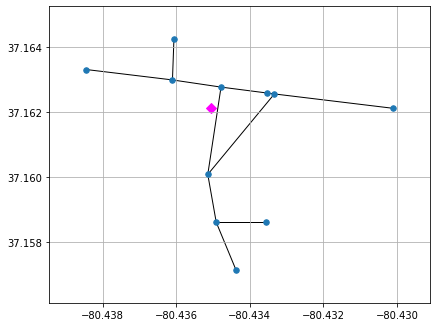

In [4]:
# Specify required directories
workPath = os.getcwd()
csvPath = workPath + "/csv/"
libPath = workPath + "/Libraries/"

# Import user defined libraries
sys.path.append(libPath)
from pyExtractDatalib import Query
from pyMapElementslib import MapLink

# Load the data from the directory
q_object = Query(csvPath)
gdf_home,homes = q_object.GetHomes()
roads = q_object.GetRoads(level=[1,2,3,4,5])

# Take a sample home coordinate and some road nodes
h = 511210211001462
nlist = [889535586, 889535587, 335455019, 171517423, 171517458, 
	171517427, 171517461, 24866230, 922394295, 24866232,171517462]

# Define a named tuple interest to store a road network subgraph of interest
interest_graph = nx.subgraph(roads.graph,nlist).copy()
interest_cords = {n:roads.cord[n] for n in nlist}
interest_obj = nt("network",field_names=["graph","cord"])
interest = interest_obj(graph=interest_graph,cord=interest_cords)
xmin = min([c[0] for c in list(interest_cords.values())])-0.001
xmax = max([c[0] for c in list(interest_cords.values())])+0.001
ymin = min([c[1] for c in list(interest_cords.values())])-0.001
ymax = max([c[1] for c in list(interest_cords.values())])+0.001

# Display the residential node along with the links
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(221)
nx.draw_networkx(interest.graph,pos=interest.cord,ax=ax1,
                 with_labels=False,node_size=30,edge_color='black')
ax1.scatter(homes.cord[h][0],homes.cord[h][1],marker='D',s=50,c='magenta')
ax1.grid(b=True)
ax1.set_xlim(xmin,xmax)
ax1.set_ylim(ymin,ymax)
ax1.tick_params(axis='both',left=True,bottom=True,labelleft=True,labelbottom=True)


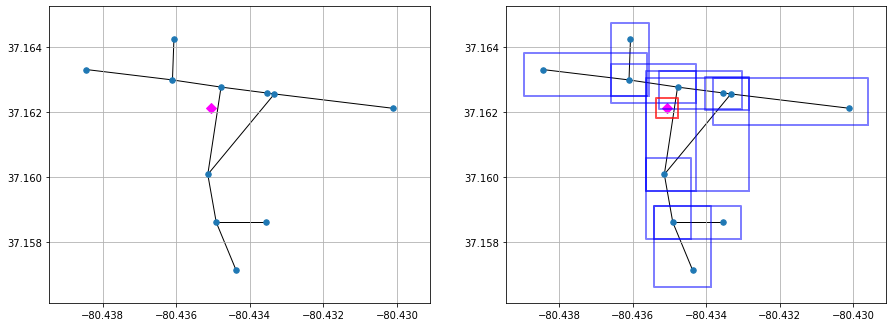

In [5]:
# Import further necessary modules
from shapely.geometry import box,Point

# Define an object for the class MapLink with radius of 5e-4
M = MapLink(interest,radius=0.0005)
lines = M.lines

# Display the original network
ax2 = fig.add_subplot(222)
nx.draw_networkx(interest.graph,pos=interest.cord,ax=ax2,
                 with_labels=False,node_size=30,edge_color='black')
ax2.scatter(homes.cord[h][0],homes.cord[h][1],marker='D',s=50,c='magenta')
ax2.grid(b=True)
ax2.set_xlim(xmin,xmax)
ax2.set_ylim(ymin,ymax)
ax2.tick_params(axis='both',left=True,bottom=True,labelleft=True,labelbottom=True)
ax2.update_from(ax1)

# Display the bounding boxes around each road network link
for lobj in lines:
    x1,y1,x2,y2 = lobj[1]
    b = box(x1,y1,x2,y2)
    x,y = list(b.exterior.xy)
    ax2.plot(x,y,color='blue',alpha=0.5,linewidth=2)

# Display the bounding box for the residential coordinate
pt = Point(homes.cord[h])
radius = 0.0003
b = box(pt.x-radius, pt.y-radius, pt.x+radius, pt.y+radius)
x,y = list(b.exterior.xy)
ax2.plot(x,y,color='red',alpha=0.7,linewidth=2)
display.display(fig)

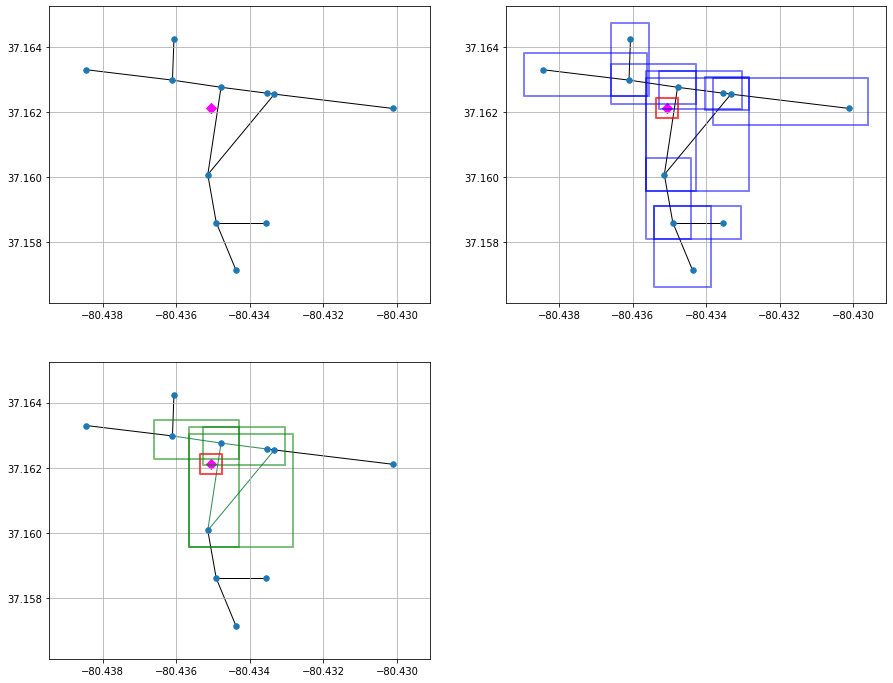

In [6]:
# Find intersections of bounding boxes
pt_bounds = pt.x-radius, pt.y-radius, pt.x+radius, pt.y+radius
matches = M.idx.intersect(pt_bounds)

match_link = [l[2] for i,l in enumerate(lines) if i in matches]
color = ['seagreen' if e in  match_link or (e[1],e[0]) in match_link else 'black' \
         for e in list(interest.graph.edges())]

# Display the residential node along with the links
ax3 = fig.add_subplot(223)
nx.draw_networkx(interest.graph,pos=interest.cord,ax=ax3,
                 with_labels=False,node_size=30,edge_color=color)
ax3.scatter(homes.cord[h][0],homes.cord[h][1],marker='D',s=50,c='magenta')
ax3.grid(b=True)
ax3.set_xlim(xmin,xmax)
ax3.set_ylim(ymin,ymax)
ax3.tick_params(axis='both',left=True,bottom=True,labelleft=True,labelbottom=True)

# Display the bounding box for the residential coordinate
pt = Point(homes.cord[h])
radius = 0.0003
b = box(pt.x-radius, pt.y-radius, pt.x+radius, pt.y+radius)
x,y = list(b.exterior.xy)
ax3.plot(x,y,color='red',alpha=0.7,linewidth=2)

# Draw the links which have bounding box intersections
for i,lobj in enumerate(lines):
    if i in matches:
        x1,y1,x2,y2 = lobj[1]
        b = box(x1,y1,x2,y2)
        x,y = list(b.exterior.xy)
        ax3.plot(x,y,color='green',alpha=0.5,linewidth=2)

display.display(fig)

The nearest link is : (171517458, 24866230)


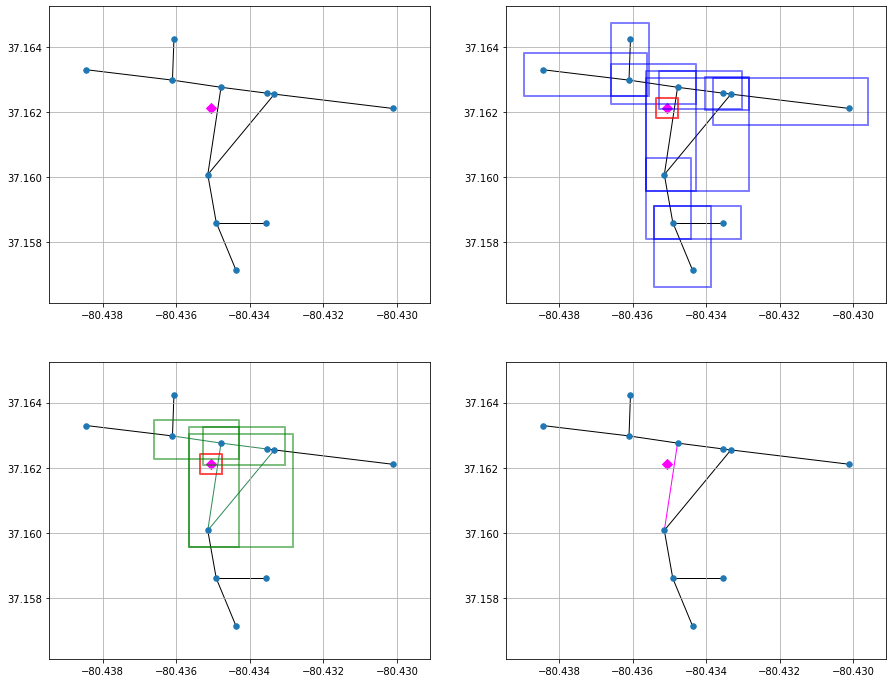

In [7]:
# Find the nearest link among the short-listed links whose bounding boxes have intersected.
closest_path = min(matches, key=lambda i: M.lines[i][0].distance(pt))
nearest = M.lines[closest_path][-1]
print("The nearest link is :",nearest)

# Display the residential node along with the links
color = ['magenta' if e ==  nearest or (e[1],e[0]) == nearest else 'black' \
         for e in list(interest.graph.edges())]
ax4 = fig.add_subplot(224)
nx.draw_networkx(interest.graph,pos=interest.cord,ax=ax4,
                 with_labels=False,node_size=30,edge_color=color)
ax4.scatter(homes.cord[h][0],homes.cord[h][1],marker='D',s=50,c='magenta')
ax4.grid(b=True)
ax4.set_xlim(xmin,xmax)
ax4.set_ylim(ymin,ymax)
ax4.tick_params(axis='both',left=True,bottom=True,labelleft=True,labelbottom=True)

display.display(fig)